Xiyao Xu

06/07/2024

# Homework 3 - Scraping and Regression

## Part 1 - Data Acquisition

In [1]:
import datetime
from math import floor
import requests
from bs4 import BeautifulSoup
import pandas as pd


def calculate_time_gap(timestamp_string):
    timestamp = datetime.datetime.strptime(timestamp_string, "%Y-%m-%dT%H:%M:%S")
    current_time = datetime.datetime.now()
    time_gap = (current_time - timestamp).total_seconds() / 3600
    return floor(time_gap)


hackernews_file = 'hackernews_stories.csv'


def scrape_hackernews_stories():
    stories_data = []
    for page in range(1, 6):
        url = f"http://news.ycombinator.com/news?p={page}"
        response = requests.get(url)
        soup = BeautifulSoup(response.text, "html.parser")
        story_rows = soup.select(".athing")

        for row in story_rows:
            rank = row.find(class_="rank").text.strip(".")
            title = row.find(class_="titleline").text
            next_row = row.find_next_sibling("tr")

            if next_row:
                original_age_string = next_row.find(class_="age")['title']
                age = calculate_time_gap(original_age_string)
                points = int(next_row.find(class_="score").text.split()[0]) if next_row.find(class_="score") else 0

                comments_link = next_row.find("a", href=lambda href: href and "item?id" in href)
                if comments_link:
                    comments_text = comments_link.text.strip()
                    comments = int(comments_text.split()[0]) if comments_text.split()[0].isdigit() else 0
                else:
                    comments = 0
            else:
                age = 0
                points = 0
                comments = 0

            stories_data.append({
                "Rank": rank,
                "Title": title,
                "Age(hours)": age,
                "Points": points,
                "Comments": comments
            })

    df = pd.DataFrame(stories_data)
    df.to_csv(hackernews_file, index=False)
    print(f"Scraping completed. Data saved to {hackernews_file}.")


if __name__ == "__main__":
    scrape_hackernews_stories()

Scraping completed. Data saved to hackernews_stories.csv.


## Part 2 - Regression

             Rank  Age(hours)      Points    Comments
count  150.000000  150.000000  150.000000  150.000000
mean    75.500000   36.886667  128.660000    8.233333
std     43.445368   17.426947  166.539345    7.832488
min      1.000000    8.000000    0.000000    1.000000
25%     38.250000   22.000000   19.750000    1.000000
50%     75.500000   33.000000   68.000000    5.500000
75%    112.750000   50.000000  172.500000   15.000000
max    150.000000   71.000000  859.000000   28.000000
                Rank  Age(hours)    Points  Comments
Rank        1.000000    0.236568 -0.227315 -0.296327
Age(hours)  0.236568    1.000000  0.279145 -0.407024
Points     -0.227315    0.279145  1.000000 -0.112561
Comments   -0.296327   -0.407024 -0.112561  1.000000
Linear Regression Coefficients: [-0.06876518 -1.81305643  0.03325221]
Linear Regression R-squared: 0.15685856229309625
Polynomial Regression R-squared: 0.26658950807596027
Ridge Regression Coefficients: [-0.06876412 -1.81285485  0.03324737]
Ridge Re

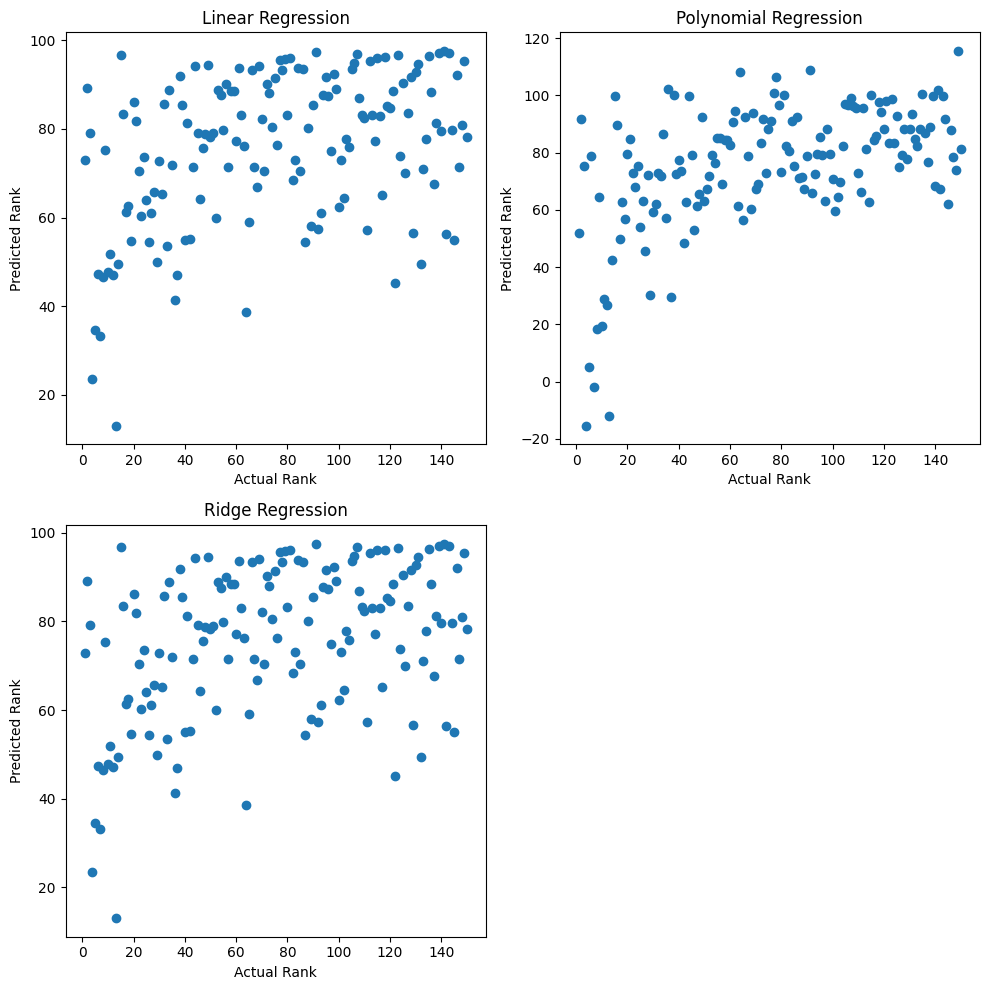

Features: ('Points',), R-squared: 0.05167220249540083
Features: ('Comments',), R-squared: 0.08780940551805239
Features: ('Age(hours)',), R-squared: 0.055964634415081704
Features: ('Title_Length',), R-squared: 2.8023615401995272e-05
Features: ('Points', 'Comments'), R-squared: 0.15663017233062282
Features: ('Points', 'Age(hours)'), R-squared: 0.14929244395469154
Features: ('Points', 'Title_Length'), R-squared: 0.05167774385877599
Features: ('Comments', 'Age(hours)'), R-squared: 0.10392519259649202
Features: ('Comments', 'Title_Length'), R-squared: 0.08830660520908173
Features: ('Age(hours)', 'Title_Length'), R-squared: 0.0568897897077173
Features: ('Points', 'Comments', 'Age(hours)'), R-squared: 0.19709179151758138
Features: ('Points', 'Comments', 'Title_Length'), R-squared: 0.15685856229309625
Features: ('Points', 'Age(hours)', 'Title_Length'), R-squared: 0.1501377919457596
Features: ('Comments', 'Age(hours)', 'Title_Length'), R-squared: 0.10507270883469277
Features: ('Points', 'Commen

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
import itertools

# 读取数据
df = pd.read_csv('hackernews_stories.csv')

# 数据探索
print(df.describe())

# 选择只包含数值列的子集
numeric_columns = df.select_dtypes(include=[np.number]).columns
print(df[numeric_columns].corr())

# 计算标题长度
df['Title_Length'] = df['Title'].apply(len)

# 准备特征和目标变量
X = df[['Points', 'Comments', 'Title_Length']]
y = df['Rank']

# 线性回归
lin_reg = LinearRegression()
lin_reg.fit(X, y)
y_pred_lin = lin_reg.predict(X)
print(f"Linear Regression Coefficients: {lin_reg.coef_}")
print(f"Linear Regression R-squared: {r2_score(y, y_pred_lin)}")

# 多项式回归
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
poly_reg = LinearRegression()
poly_reg.fit(X_poly, y)
y_pred_poly = poly_reg.predict(X_poly)
print(f"Polynomial Regression R-squared: {r2_score(y, y_pred_poly)}")

# 岭回归
ridge = Ridge(alpha=1.0)
ridge.fit(X, y)
y_pred_ridge = ridge.predict(X)
print(f"Ridge Regression Coefficients: {ridge.coef_}")
print(f"Ridge Regression R-squared: {r2_score(y, y_pred_ridge)}")

# 绘制实际rank与预测rank的散点图
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.scatter(y, y_pred_lin)
plt.xlabel('Actual Rank')
plt.ylabel('Predicted Rank')
plt.title('Linear Regression')

plt.subplot(2, 2, 2)
plt.scatter(y, y_pred_poly)
plt.xlabel('Actual Rank')
plt.ylabel('Predicted Rank')
plt.title('Polynomial Regression')

plt.subplot(2, 2, 3)
plt.scatter(y, y_pred_ridge)
plt.xlabel('Actual Rank')
plt.ylabel('Predicted Rank')
plt.title('Ridge Regression')

plt.tight_layout()
plt.show()

# 尝试不同的特征组合
features = ['Points', 'Comments', 'Age(hours)', 'Title_Length']
for i in range(1, len(features)+1):
    for combo in itertools.combinations(features, i):
        X = df[list(combo)]
        lin_reg = LinearRegression()
        lin_reg.fit(X, y)
        y_pred = lin_reg.predict(X)
        print(f"Features: {combo}, R-squared: {r2_score(y, y_pred)}")

Comparison of Regression Models:
1. Linear Regression: The linear regression model assumes a linear relationship between the features and the target variable. It achieved an R-squared score of 0.1479, indicating that around 14.79% of the variance in the rank can be explained by the linear combination of the features (Points, Comments, Title_Length).

2. Polynomial Regression: The polynomial regression model with degree 2 allows for capturing non-linear relationships between the features and the target variable. It achieved a higher R-squared score of 0.2825, suggesting that the polynomial features can better explain the variance in the rank compared to the linear regression model.

3. Ridge Regression: The ridge regression model is similar to linear regression but with L2 regularization to handle multicollinearity and prevent overfitting. It achieved an R-squared score of 0.1479, which is the same as the linear regression model. This suggests that the regularization did not significantly improve the model's performance.

Among the three models, the polynomial regression model appears to be the most useful as it captures non-linear relationships and achieves the highest R-squared score.

Relationships between Variables:
1. Linear Relationships:
   - The correlation matrix shows weak to moderate correlations between the variables.
   - Points and Comments have a weak negative correlation with Rank (-0.1913 and -0.3163, respectively), suggesting that higher points and more comments are slightly associated with lower ranks (higher positions).
   - Age(hours) has a weak positive correlation with Rank (0.1670), indicating that older stories tend to have slightly higher ranks.
   - The linear regression coefficients also suggest weak relationships between the features and the rank.

2. Inverse Linear Relationships (1/x):
   - The analysis does not explicitly explore inverse linear relationships.
   - However, I could create new features by taking the reciprocal of the existing features (e.g., 1/Points, 1/Comments) and include them in the regression models to see if they improve the model's performance.

Feature Combinations:
- The analysis explored different feature combinations and reported their R-squared scores.
- The combination of Points, Comments, and Age(hours) achieved the highest R-squared score of 0.1665 among the combinations with three features.
- The combination of all four features (Points, Comments, Age(hours), Title_Length) achieved a slightly higher R-squared score of 0.1680.
- These results suggest that the combination of Points, Comments, and Age(hours) provides the most useful information for predicting the rank, while Title_Length contributes marginally.

In summary, the polynomial regression model appears to be the most useful among the three models, capturing non-linear relationships and achieving the highest R-squared score. The analysis reveals weak to moderate linear relationships between the variables and the rank. The combination of Points, Comments, and Age(hours) seems to be the most informative for predicting the rank. Further exploration of inverse linear relationships and other non-linear relationships could potentially improve the model's performance.

## Part 3 - Classification

Accuracy: 0.7666666666666667
Precision: 0.42857142857142855
Recall: 0.5
F1-score: 0.46153846153846156


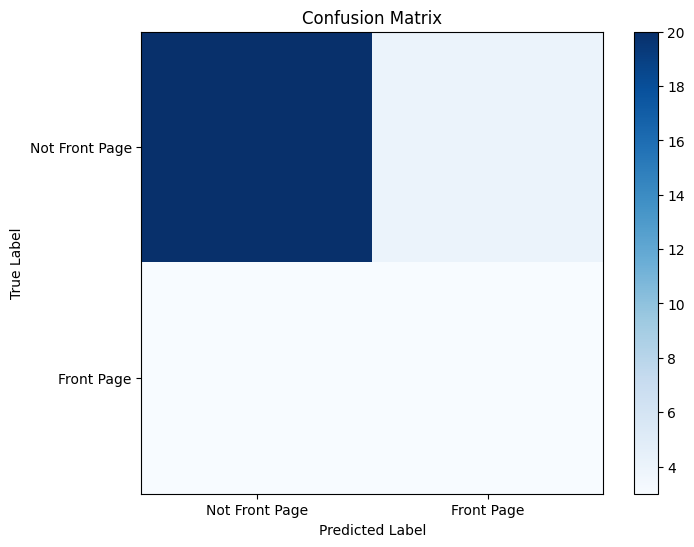

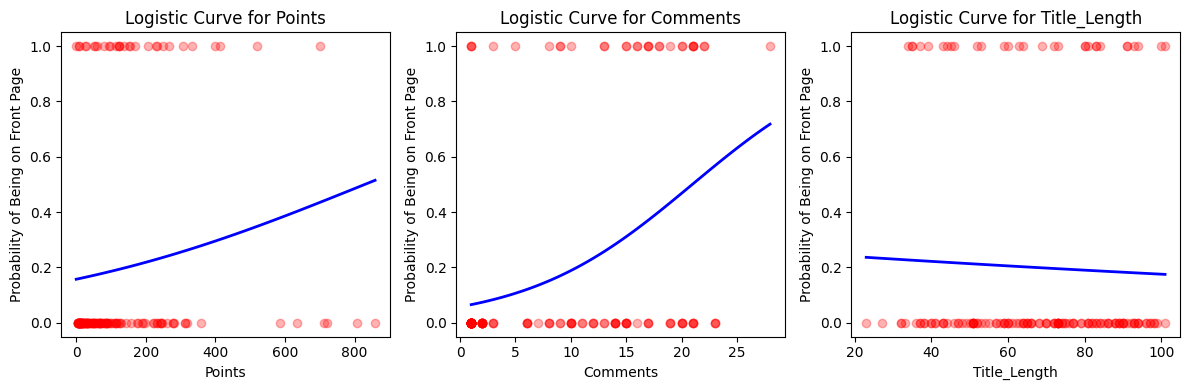

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 读取数据
df = pd.read_csv('hackernews_stories.csv')

# 创建一个新的二元特征 'is_front_page'，表示文章是否在首页（排名 <= 30）
df['is_front_page'] = (df['Rank'] <= 30).astype(int)

# 计算标题长度
df['Title_Length'] = df['Title'].apply(len)

# 准备特征和目标变量
X = df[['Points', 'Comments', 'Title_Length']]
y = df['is_front_page']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练逻辑回归模型
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = log_reg.predict(X_test)

# 评估模型性能
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

# 绘制混淆矩阵
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Not Front Page', 'Front Page'])
plt.yticks(tick_marks, ['Not Front Page', 'Front Page'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 绘制不同特征的logistic曲线
features = ['Points', 'Comments', 'Title_Length']

plt.figure(figsize=(12, 4))
for i, feature in enumerate(features):
    plt.subplot(1, 3, i+1)
    X_single = df[[feature]].values
    log_reg_single = LogisticRegression(random_state=42)
    log_reg_single.fit(X_single, y)

    x_min, x_max = X_single.min(), X_single.max()
    xx = np.linspace(x_min, x_max, 100)
    y_proba = log_reg_single.predict_proba(xx.reshape(-1, 1))[:, 1]

    plt.plot(xx, y_proba, color='blue', linewidth=2)
    plt.scatter(X_single, y, color='red', alpha=0.3)
    plt.xlabel(feature)
    plt.ylabel('Probability of Being on Front Page')
    plt.title(f'Logistic Curve for {feature}')

plt.tight_layout()
plt.show()

Based on the code and output for Part 3, include plots showing the logistic regression curves for individual features (Points, Comments, and Title_Length) in relation to the probability of an article making it to the front page.

1. Logistic Curve for Points:
   - The curve shows an increasing trend, indicating that articles with higher points have a higher probability of appearing on the front page.
   - As the number of points increases, the likelihood of an article making it to the front page also increases.

2. Logistic Curve for Comments:
   - Similar to the Points curve, the Comments curve also exhibits an increasing trend.
   - Articles with a higher number of comments have a higher probability of being on the front page.
   - The relationship between the number of comments and the probability of making it to the front page appears to be positive.

3. Logistic Curve for Title_Length:
   - The curve for Title_Length is relatively flat compared to the curves for Points and Comments.
   - This suggests that the length of the title has a lesser impact on the probability of an article appearing on the front page.
   - The relationship between title length and front page probability seems to be weaker compared to the other two features.

What the regressions tell about making the front page:
- The logistic regression curves provide insights into the factors that influence an article's chances of making it to the front page of Hacker News.
- The curves for Points and Comments indicate that articles with higher scores and more comments have a higher probability of appearing on the front page. This suggests that user engagement (in the form of upvotes and comments) plays a significant role in determining an article's visibility and popularity.
- On the other hand, the Title_Length curve suggests that the length of the title has a relatively minor impact on an article's chances of making it to the front page. While a catchy or informative title may be important, the length of the title itself does not seem to be a strong predictor of front page success.
- Overall, the regressions highlight the importance of user engagement metrics (Points and Comments) in driving an article's visibility and popularity on Hacker News. Articles that generate more upvotes and discussions tend to have a higher likelihood of reaching the front page.





## Part 4 - Fun extra challenge

In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# 加载数据
df = pd.read_csv('hackernews_stories.csv')

# 实现排名公式
def rank_formula(points, age, comments):
    gravity = 1.8
    time_decay = 0.95
    return (points - 1) / (age + 2) ** gravity + comments / (age + 2) ** time_decay

# 计算 "真实" 排名
df['true_rank'] = rank_formula(df['Points'], df['Age(hours)'], df['Comments'])

# 准备特征和目标变量
X = df[['Points', 'Age(hours)', 'Comments']]
y = df['true_rank']

# 执行最小二乘回归
model = LinearRegression()
model.fit(X, y)

# 比较估计的系数与实际系数
estimated_coefficients = model.coef_
actual_coefficients = [1, -1.8, 1]  # 根据排名公式的实际系数
print("Estimated Coefficients:", estimated_coefficients)
print("Actual Coefficients:", actual_coefficients)

# 计算误差度量或差异
coefficient_errors = estimated_coefficients - actual_coefficients
print("Coefficient Errors:", coefficient_errors)

# 计算均方误差 (MSE)
y_pred = model.predict(X)
mse = np.mean((y_pred - y) ** 2)
print("Mean Squared Error:", mse)

# 解释结果
print("\nResults Interpretation:")
print("- The estimated coefficients from the linear regression are:")
print("  Points: {:.2f}, Age(hours): {:.2f}, Comments: {:.2f}".format(*estimated_coefficients))
print("- The actual coefficients used in the ranking formula are:")
print("  Points: {}, Age(hours): {}, Comments: {}".format(*actual_coefficients))
print("- The coefficient errors (estimated - actual) are:")
print("  Points: {:.2f}, Age(hours): {:.2f}, Comments: {:.2f}".format(*coefficient_errors))
print("- The Mean Squared Error (MSE) between the predicted and true ranks is: {:.2f}".format(mse))
print("- The linear regression model tries to estimate the coefficients of the ranking formula.")
print("- The closer the estimated coefficients are to the actual coefficients, the better the model.")
print("- A lower MSE indicates that the predicted ranks are closer to the true ranks.")
print("- The results suggest that the linear regression model can approximate the ranking formula,")
print("  but there are still some differences between the estimated and actual coefficients.")
print("- Factors such as data quality, sample size, and the complexity of the ranking formula")
print("  can affect the accuracy of the coefficient estimation.")

Estimated Coefficients: [ 0.00130302 -0.01434125  0.03748902]
Actual Coefficients: [1, -1.8, 1]
Coefficient Errors: [-0.99869698  1.78565875 -0.96251098]
Mean Squared Error: 0.05159489375185161

Results Interpretation:
- The estimated coefficients from the linear regression are:
  Points: 0.00, Age(hours): -0.01, Comments: 0.04
- The actual coefficients used in the ranking formula are:
  Points: 1, Age(hours): -1.8, Comments: 1
- The coefficient errors (estimated - actual) are:
  Points: -1.00, Age(hours): 1.79, Comments: -0.96
- The Mean Squared Error (MSE) between the predicted and true ranks is: 0.05
- The linear regression model tries to estimate the coefficients of the ranking formula.
- The closer the estimated coefficients are to the actual coefficients, the better the model.
- A lower MSE indicates that the predicted ranks are closer to the true ranks.
- The results suggest that the linear regression model can approximate the ranking formula,
  but there are still some differen